# MNIST for ML Beginners

- This tutorial goes through the code in [`mnist_softmax.py`](https://github.com/tensorflow/tensorflow/blob/v0.10.0/tensorflow/examples/tutorials/mnist/mnist_softmax.py) line by line.

In [6]:
import tensorflow as tf
from IPython.display import display, Math, Latex, Image

In [1]:
# Download the MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


- The MNIST data is split into three parts:
    - 55,000 data points of training data (mnist.train)
    - 10,000 points of test data (mnist.test)
    - 5,000 points of validation data (mnist.validation)

- [Visualizing the MNIST data](http://colah.github.io/posts/2014-10-Visualizing-MNIST/)

- Each MNIST image is a 28 x 28 pixel image of a handwritten digit.
- We will be flattening the image into a vector (or "tensor") of 784 dimensions, each dimension representing a pixel's intensity (a value between 0 and 1).
- Since there are 55K images, our training data, `mnist.train.images`, will have the shape [55000, 784].
- Each image has a corresponding label from 0 to 9.
- We will represent our labels in "one-hot" encoding, where each label will be a 10-dimension vector with one dimension "switched on", e.g. 3 would be [0, 0, 0, 1, 0, 0, 0, 0, 0, 0].
- Our training labels, `mnist.train.labels`, will have the shape [55000, 10].
- Objective: Given an image, produce a set of probabilities for each label.
- This is a classic case where a softmax regression is a natural, simple model. If you want to assign probabilities to an object being one of several different things, softmax is the thing to do, because softmax gives us a list of values between 0 and 1 that add up to 1.

## Softmax Regressions

1. Add up the evidence of our input being in certain classes
2. Convert that evidence into probabilities

- To tally up the evidence that a given image is in a particular class, we do a weighted sum of the pixel intensities. The weight is negative if that pixel having a high intensity is evidence against the image being in that class, and positive if it is evidence in favor.
- We also add some extra evidence called a bias. Basically, we want to be able to say that some things are more likely independent of the input.

In [12]:
display(Math(r'\text{evidence}_i = \sum_j W_{i,~ j} x_j + b_i'))
display(Math(r'\text{where }W_i\text{ is the weights and }b_i\text{ is the bias for class }i\text{, and }j\text{ is an index for summing over the pixels in our input image }x'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

- We then convert the evidence tallies into our predicted probabilities y using the "softmax" function:

In [10]:
display(Math(r'y = \text{softmax}(\text{evidence})'))

<IPython.core.display.Math object>

- Here softmax is serving as an "activation" or "link" function, shaping the output of our linear function into the form we want -- in this case, a probability distribution over 10 cases. You can think of it as converting tallies of evidence into probabilities of our input being in each class.

In [13]:
display(Math(r'\text{softmax}(x) = \text{normalize}(\exp(x))'))

<IPython.core.display.Math object>

or

In [14]:
display(Math(r'\text{softmax}(x)_i = \frac{\exp(x_i)}{\sum_j \exp(x_j)}'))

<IPython.core.display.Math object>

- You can picture our softmax regression as looking something like the following, although with a lot more xs. For each output, we compute a weighted sum of the xs, add a bias, and then apply softmax.

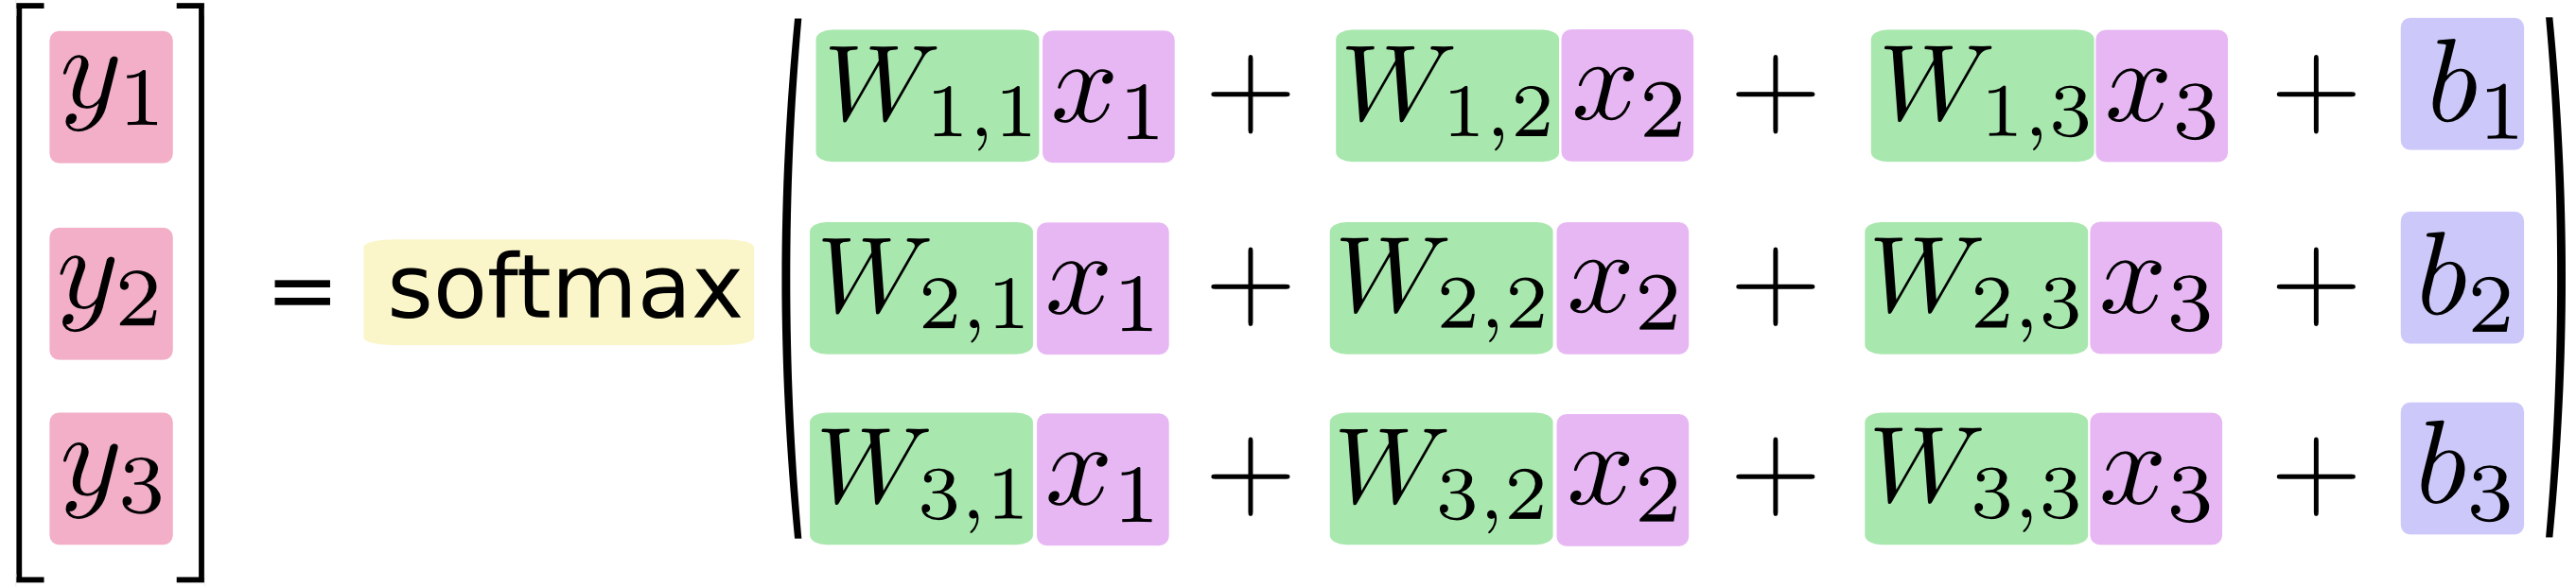

In [3]:
Image(filename='../MNIST_for_ML_Beginners/softmax-regression-scalarequation.png')

- Or, as a vectorized operation:

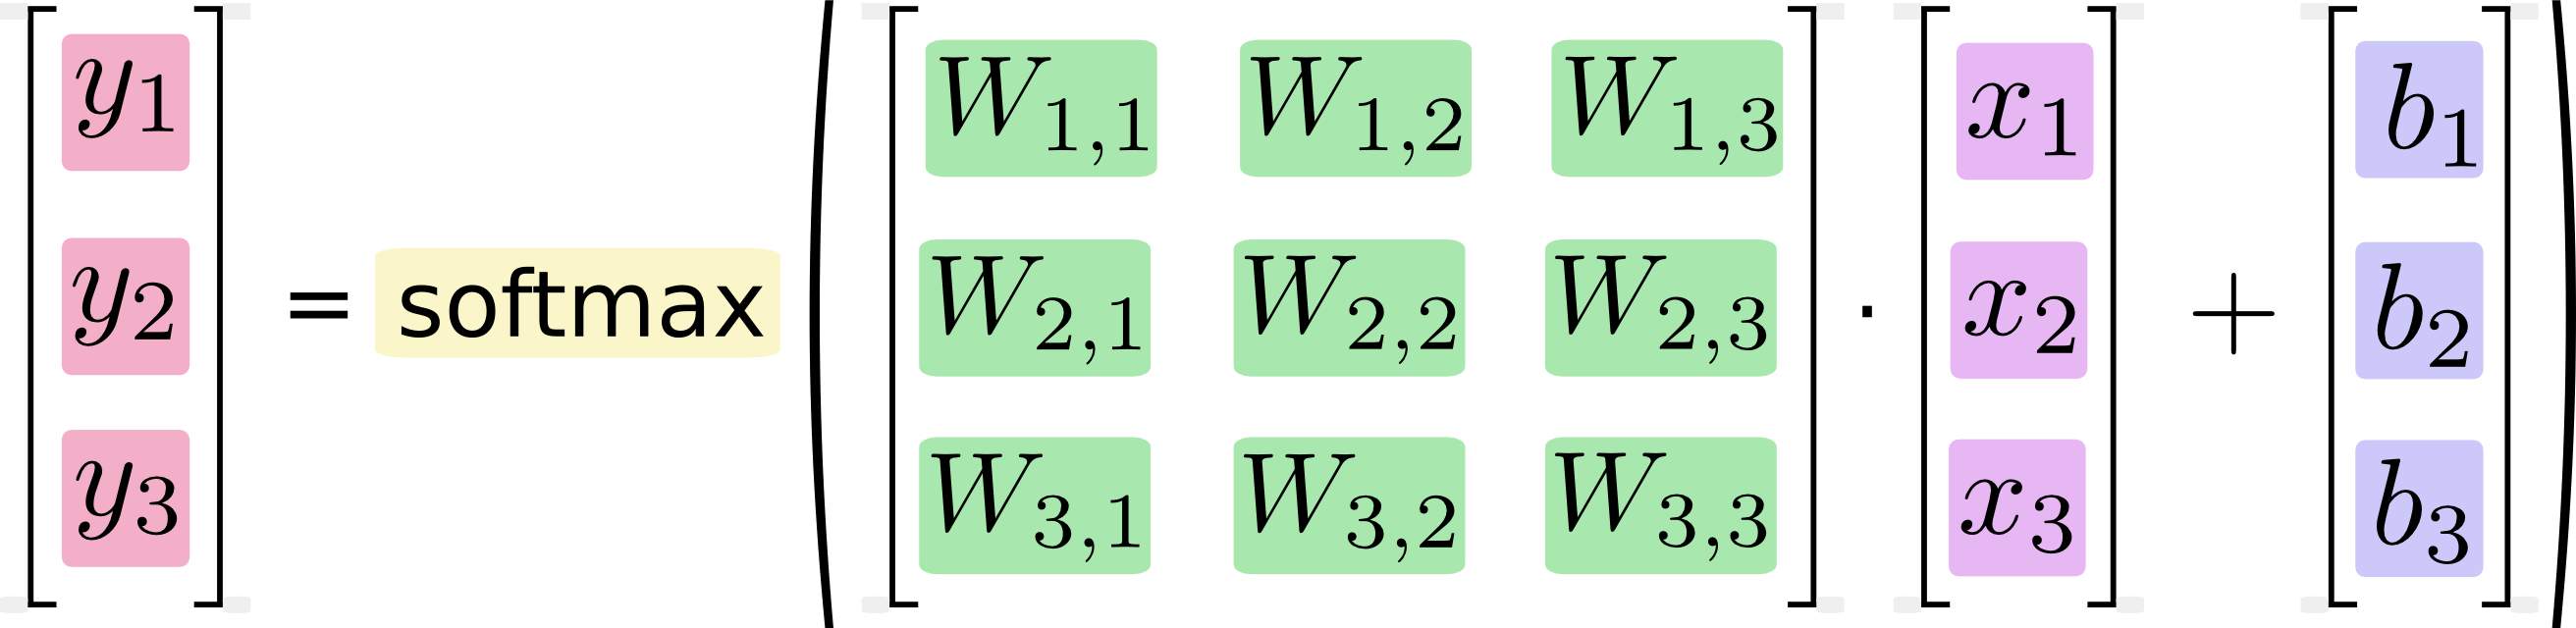

In [4]:
Image(filename='../MNIST_for_ML_Beginners/softmax-regression-vectorequation.png')

- More compactly, we can just write:

In [5]:
display(Math(r'y = \text{softmax}(Wx + b)'))

<IPython.core.display.Math object>

- More information about [softmax regression](http://neuralnetworksanddeeplearning.com/chap3.html#softmax)

## Implementing the Regression

- In TensorFlow, one makes a graph of interacting operations, first defining placeholder variables.
- We want to be able to input any number of MNIST images, each flattened into a 784-dimensional vector. We represent this as a 2-D tensor of floating-point numbers, with a shape [None, 784]. (Here None means that a dimension can be of any length.)

In [7]:
x = tf.placeholder(tf.float32, [None, 784])

- We also need the weights and biases for our model. We could imagine treating these like additional inputs, but TensorFlow has an even better way to handle it: `Variable`. A `Variable` is a modifiable tensor that lives in TensorFlow's graph of interacting operations. It can be used and even modified by the computation. For machine learning applications, one generally has the model parameters be `Variable`s.
- We initialize both `W` and `b` as tensors full of zeros. Since we are going to learn `W` and `b`, it doesn't matter very much what they initially are.

In [8]:
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

- We can now implement our model. It only takes one line to define it!

In [9]:
y = tf.nn.softmax(tf.matmul(x, W) + b)

- First, we multiply `x` by `W` with the expression `tf.matmul(x, W)`. This is flipped from when we multiplied them in our equation, where we had `Wx`, as a small trick to deal with `x` being a 2D tensor with multiple inputs. We then add `b`, and finally apply `tf.nn.softmax`.

## Training the Model

- In order to train our model, we need to define what it means for the model to be good. Well, actually, in machine learning we typically define what it means for a model to be bad. We call this the cost, or the loss, and it represents how far off our model is from our desired outcome. We try to minimize that error, and the smaller the error margin, the better our model is.
- One very common, very nice function to determine the loss of a model is called "cross-entropy."
- More information about ["cross-entropy"](http://colah.github.io/posts/2015-09-Visual-Information/).

In [13]:
display(Math(r"H_{y'}(y) = -\sum_i y'_i \log(y_i)"))

<IPython.core.display.Math object>

In [15]:
display(Math(r"\text{Where }y\text{ is our predicted probability distribution, and }y′\text{ is the true distribution (the one-hot vector with the digit labels).}"))

<IPython.core.display.Math object>

- To implement cross-entropy we need to first add a new placeholder to input the correct answers:

In [16]:
y_ = tf.placeholder(tf.float32, [None, 10])

- Then we can implement the cross-entropy function:

In [17]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

- First, `tf.log` computes the logarithm of each element of `y`. Next, we multiply each element of `y_` with the corresponding element of `tf.log(y)`. Then `tf.reduce_sum` adds the elements in the second dimension of `y`, due to the `reduction_indices=[1]` parameter. Finally, `tf.reduce_mean` computes the mean over all the examples in the batch.

- Note: In the source code, we don't use this formulation, because it is numerically unstable. Instead, we apply `tf.nn.softmax_cross_entropy_with_logits` on the unnormalized logits (e.g., we call `softmax_cross_entropy_with_logits` on `tf.matmul(x, W) + b`), because this more numerically stable function internally computes the softmax activation. In your code, consider using `tf.nn.(sparse_)softmax_cross_entropy_with_logits` instead.

- Now that we know what we want our model to do, it's very easy to have TensorFlow train it to do so.
- Because TensorFlow knows the entire graph of your computations, it can automatically use the [backpropagation algorithm](http://colah.github.io/posts/2015-08-Backprop/) to efficiently determine how your variables affect the loss you ask it to minimize.
- Then it can apply your choice of optimization algorithm to modify the variables and reduce the loss.

In [18]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

- In this case, we ask TensorFlow to minimize `cross_entropy` using the [gradient descent algorithm](https://en.wikipedia.org/wiki/Gradient_descent) with a learning rate of 0.5.
- Gradient descent is a simple procedure, where TensorFlow simply shifts each variable a little bit in the direction that reduces the cost.
- But TensorFlow also provides [many other optimization algorithms](https://www.tensorflow.org/api_docs/python/train#optimizers): using one is as simple as tweaking one line.

- Now we have our model set up to train. One last thing before we launch it, we have to create an operation to initialize the variables we created. Note that this defines the operation but does not run it yet:

In [19]:
init = tf.global_variables_initializer()

AttributeError: module 'tensorflow' has no attribute 'global_variables_initializer'